In [59]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim

# Download historical stock prices for Apple Inc. (AAPL)
ticker = 'AAPL'
start_date = '2010-01-01'
end_date = '2022-01-01'
stock_data = yf.download(ticker, start=start_date, end=end_date)
data = stock_data[['Close']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Create a sliding window of the data
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 100
X, y = create_dataset(data['Close'], window_size)

[*********************100%***********************]  1 of 1 completed


/var/folders/ry/zvcgljf15d9_jhs8whdkl72r0000gn/T/ipykernel_1675/1926658172.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))


In [60]:
#Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert the data into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [61]:
class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, activation):
        super(LSTMLayer, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.activation = activation

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.activation(x)
        return x


In [62]:
from torch.utils.data import DataLoader, TensorDataset

# Convert the data into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert the data into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)


/var/folders/ry/zvcgljf15d9_jhs8whdkl72r0000gn/T/ipykernel_1675/3049309044.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
/var/folders/ry/zvcgljf15d9_jhs8whdkl72r0000gn/T/ipykernel_1675/3049309044.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
/var/folders/ry/zvcgljf15d9_jhs8whdkl72r0000gn/T/ipykernel_1675/3049309044.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, d

In [63]:
class StockPredictor(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super(StockPredictor, self).__init__()
        
        self.activation = activation()

        self.lstm1 = LSTMLayer(input_size=data.shape[1], hidden_size=128, activation=self.activation)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.lstm2 = LSTMLayer(input_size=128, hidden_size=64, activation=self.activation)
        self.batch_norm2 = nn.BatchNorm1d(64)

        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.lstm1(x)
        x = x.transpose(1, 2)
        x = self.batch_norm1(x)
        x = x.transpose(1, 2)
        x = self.lstm2(x)
        x = x.transpose(1, 2)
        x = self.batch_norm2(x)
        x = x.transpose(1, 2)

        x = self.fc(x[:, -1, :])
        return x

# Create the model with the best parameters
model = StockPredictor(activation=nn.ReLU)

# Create data loaders with the best batch size
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Set the optimizer with the best learning rate
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model


In [64]:
# Training settings
num_epochs = 18
criterion = nn.MSELoss()

# Train the model
model.train()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_batch)

        # Calculate the loss
        loss = criterion(y_pred, y_batch)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    # Print the loss for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Calculate the mean squared error
mse = np.mean((y_pred.detach().numpy() - y_test.numpy()) ** 2)
print(f'Mean squared error: {mse:.2f}')


/Users/sahilarora/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/18], Loss: 0.0143
Epoch [2/18], Loss: 0.0265
Epoch [3/18], Loss: 0.0204
Epoch [4/18], Loss: 0.0188
Epoch [5/18], Loss: 0.0171
Epoch [6/18], Loss: 0.0179
Epoch [7/18], Loss: 0.0224
Epoch [8/18], Loss: 0.0190
Epoch [9/18], Loss: 0.0160
Epoch [10/18], Loss: 0.0186
Epoch [11/18], Loss: 0.0193
Epoch [12/18], Loss: 0.0253
Epoch [13/18], Loss: 0.0141
Epoch [14/18], Loss: 0.0195
Epoch [15/18], Loss: 0.0134
Epoch [16/18], Loss: 0.0186
Epoch [17/18], Loss: 0.0227
Epoch [18/18], Loss: 0.0205
Mean squared error: 0.49


In [65]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Reshape the tensors
y_pred_reshaped = y_pred.numpy().reshape(-1, 1)
y_test_reshaped = y_test.numpy().reshape(-1, 1)

# Inverse transform the predictions and true values
y_pred_transformed = scaler.inverse_transform(np.hstack([y_pred_reshaped, np.zeros_like(y_pred_reshaped)]))[:, 0]
y_test_transformed = scaler.inverse_transform(np.hstack([y_test_reshaped, np.zeros_like(y_test_reshaped)]))[:, 0]

# Calculate the mean squared error
mse = np.mean((y_pred_transformed - y_test_transformed) ** 2)
print(f'Mean squared error: {mse}')

Mean squared error: 724.1746826171875


Mean squared error: 724.1746826171875


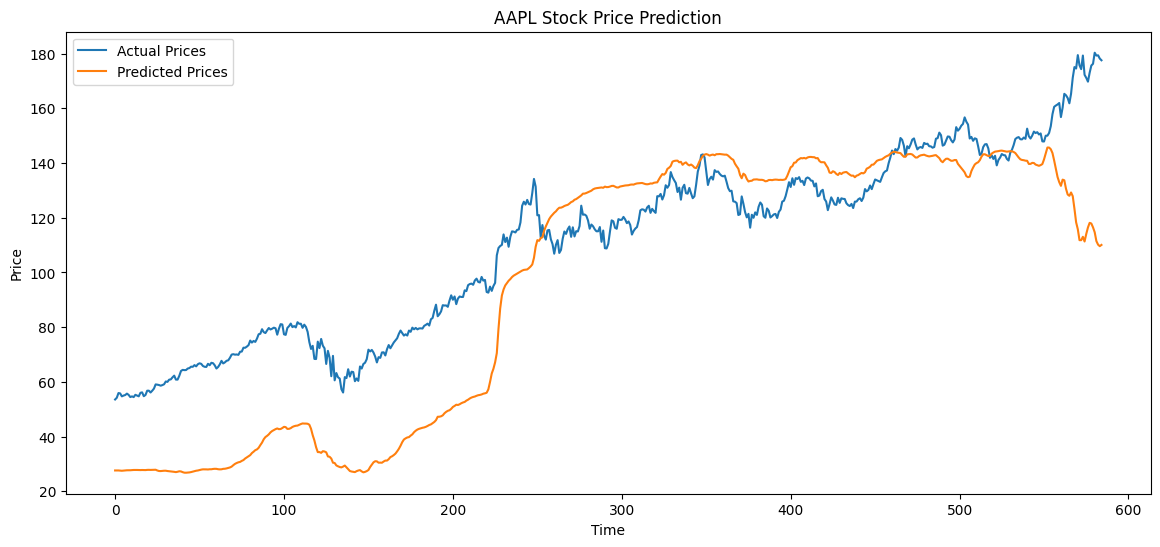

In [66]:
# Calculate the mean squared error
mse = np.mean((y_pred_transformed - y_test_transformed) ** 2)
print(f'Mean squared error: {mse}')

# Visualize the results
plt.figure(figsize=(14, 6))
plt.plot(y_test_transformed, label='Actual Prices')
plt.plot(y_pred_transformed, label='Predicted Prices')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [67]:
import pickle

# Save the model to a pickle file
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [68]:
import os
import pickle

# Download historical stock prices for Apple Inc. (AAPL)
ticker = 'AAPL'
start_date = '2010-01-01'
end_date = '2022-01-01'
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Save the dataset as a pickle file
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

with open(os.path.join(data_dir, 'stock_data.pkl'), 'wb') as f:
    pickle.dump(stock_data, f)


[*********************100%***********************]  1 of 1 completed


In [69]:
# ... (train the model as before, then make predictions)

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Reshape the tensors
y_pred_reshaped = y_pred.numpy().reshape(-1, 1)
y_test_reshaped = y_test.numpy().reshape(-1, 1)

# Inverse transform the predictions and true values
y_pred_transformed = scaler.inverse_transform(np.hstack([y_pred_reshaped, np.zeros_like(y_pred_reshaped)]))[:, 0]
y_test_transformed = scaler.inverse_transform(np.hstack([y_test_reshaped, np.zeros_like(y_test_reshaped)]))[:, 0]

# Save the predictions as a pickle file
predictions = {
    'y_pred': y_pred_transformed,
    'y_test': y_test_transformed,
}

with open(os.path.join(data_dir, 'predictions.pkl'), 'wb') as f:
    pickle.dump(predictions, f)


In [71]:
# Save the trained model
torch.save(model.state_dict(), 'model.pth')